# Exploration des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
def load_data():
    X = pd.read_csv("data/input_training.csv", index_col=0)
    y = pd.read_csv("data/output_training_gmEd6Zt.csv", index_col=0)
    return X, y

X, y = load_data()
X.head()

,day,equity,r0,r1,r2,r3,r4,r5,r6,r7,...,r43,r44,r45,r46,r47,r48,r49,r50,r51,r52
ID,,,,,,,,,,,,,,,,,,,,,
0,249,1488,0.00,NaN,NaN,NaN,0.00,NaN,NaN,-68.03,...,0.00,0.00,NaN,0.00,NaN,0.00,NaN,NaN,NaN,0.00
1,272,107,-9.76,0.00,-12.21,46.44,34.08,0.00,41.24,12.08,...,-4.83,-16.92,-4.84,4.84,0.00,7.26,-9.68,-19.38,9.71,26.68
2,323,1063,49.85,0.00,0.00,-26.64,-23.66,-22.14,49.12,53.61,...,-6.37,1.59,6.37,-49.32,-9.59,-6.40,22.41,-6.39,7.99,15.96
3,302,513,0.00,NaN,0.00,0.00,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN
4,123,1465,-123.84,-115.18,-26.44,0.00,42.42,10.56,0.00,-47.57,...,-5.36,-21.44,-21.48,10.78,-21.55,-5.40,-10.81,5.41,-32.47,43.43


In [94]:
X.shape, y.shape

((843299, 55), (843299, 1))

In [96]:
X.day.nunique(), X.equity.nunique()

(503, 1829)

In [75]:
X.iloc[0][:10]

day        249.00
equity    1488.00
r0           0.00
r1            NaN
r2            NaN
r3            NaN
r4           0.00
r5            NaN
r6            NaN
r7         -68.03
Name: 0, dtype: float64

In [93]:
y.reod[:5]

ID
0    0
1    0
2   -1
3    0
4   -1
Name: reod, dtype: int64

In [4]:
X.isna().sum(axis=1).agg(["mean", "std", "max"])

mean     5.707015
std     12.213529
max     53.000000
dtype: float64

In [76]:
X.shape

(843299, 55)

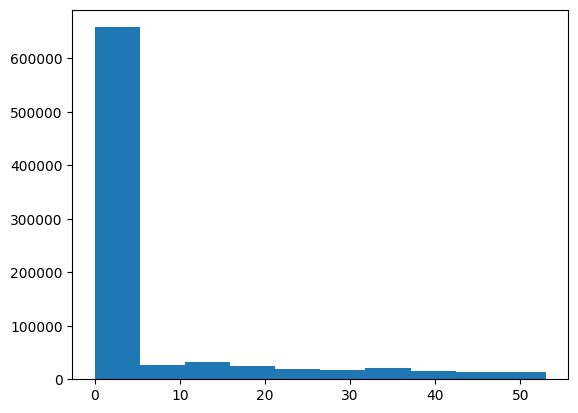

In [85]:
na_count = X.isna().sum(axis=1)
plt.hist(na_count, bins=10)
plt.savefig("images/hist_na.png")

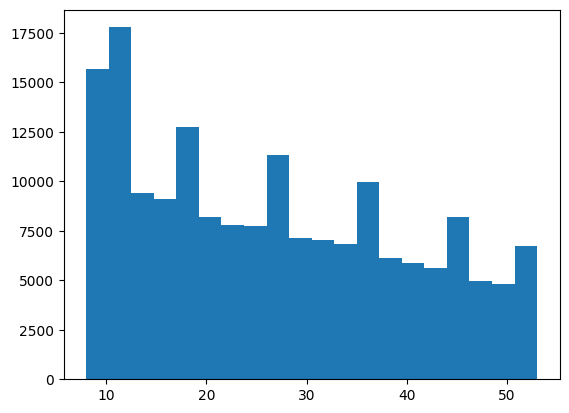

In [86]:
cond = na_count > 7
plt.hist(na_count[cond], bins=20)
plt.savefig("images/hist_na_ge7.png")

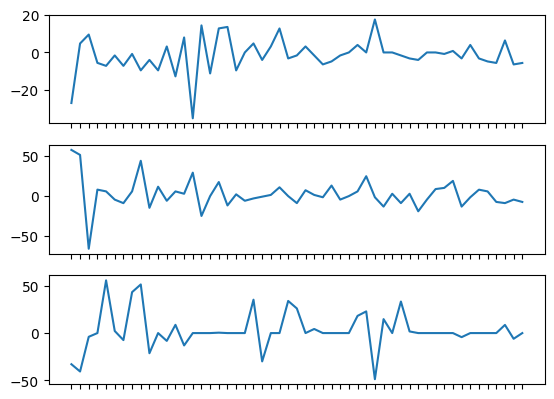

In [6]:
fig, axes = plt.subplots(3, 1)
for ax, i in zip(axes, [5, 10, 15]):
    ax.plot(X.iloc[i].drop(["day", "equity"]))
    ax.set_xticklabels([])
plt.savefig("images/obs.png")

In [7]:
columns = X.columns.to_list()[2:9]
X[columns].agg(["mean", "min", "max", "std"])

,r0,r1,r2,r3,r4,r5,r6
mean,1.839875e+03,1.935344e+02,7.011399e+01,1.956448e+01,-0.215511,0.283935,-0.313301
min,-9.967670e+03,-9.973540e+03,-4.823740e+03,-1.949690e+03,-1390.130000,-1632.290000,-1559.320000
max,4.310700e+08,7.516000e+07,4.789000e+07,1.545000e+07,2327.870000,2396.690000,2343.750000
std,6.097548e+05,1.153271e+05,5.588823e+04,1.785055e+04,44.724646,41.548517,40.706372


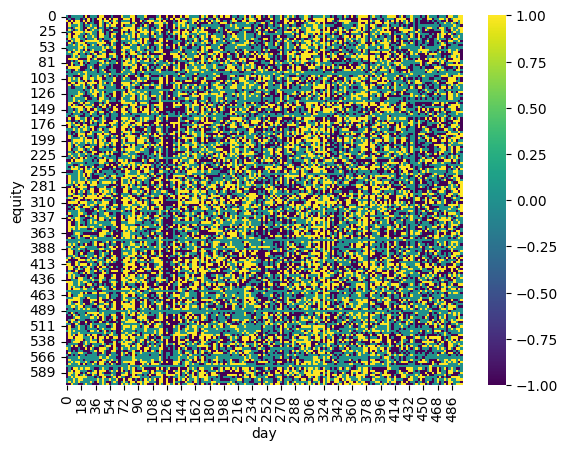

In [8]:
heatmap_data = X.merge(y, on="ID").pivot_table(
    index="equity", columns="day", values="reod"
).dropna()
sns.heatmap(
    heatmap_data.iloc[0:500:3, 0:500:3],
    cmap=plt.cm.viridis
)
plt.savefig("images/heatmap.png")

# Préparation

In [3]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.2)
X1.shape, X2.shape

((674639, 55), (168660, 55))

In [71]:
y1.reod.values[:5]

array([ 1,  0,  0,  0, -1], dtype=int64)

In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False)
y_encoded = enc.fit_transform(y1)
y_encoded[:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [70]:
enc.categories_

[array([-1,  0,  1], dtype=int64)]

In [4]:
pipe = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

def clean_targets(targets):
    return targets.reod.replace(-1, 2).values

X_train = pipe.fit_transform(X1)
X_val = pipe.transform(X2)
y_train = clean_targets(y1)
y_val = clean_targets(y2)

X_train

array([[ 1.12157974e+00, -7.12034540e-01, -3.08540733e-03, ...,
        -1.63069698e-01,  2.99153823e-01,  1.54155956e-01],
       [ 1.71871091e-01, -1.16417000e+00, -2.98205339e-03, ...,
        -4.18712248e-01,  6.75484025e-01,  2.75862184e-01],
       [ 2.95746133e-01, -8.58313660e-01, -3.66105929e-03, ...,
        -1.14800035e-02, -4.23597504e-03, -4.27833742e-18],
       ...,
       [ 2.54454452e-01, -6.61267400e-02, -2.97351546e-03, ...,
        -6.52699127e-01,  7.81194756e-01, -7.95367082e-01],
       [-6.21150987e-02,  4.82894890e-01, -3.01384984e-03, ...,
        -2.10606535e-01, -2.03500703e-01,  4.04538372e-01],
       [-5.02559692e-01, -2.20004775e-01,  0.00000000e+00, ...,
        -1.14800035e-02, -4.23597504e-03, -2.36950578e+00]])

In [11]:
y_train

array([1, 0, 2, ..., 1, 2, 0], dtype=int64)

# Forêts aléatoires

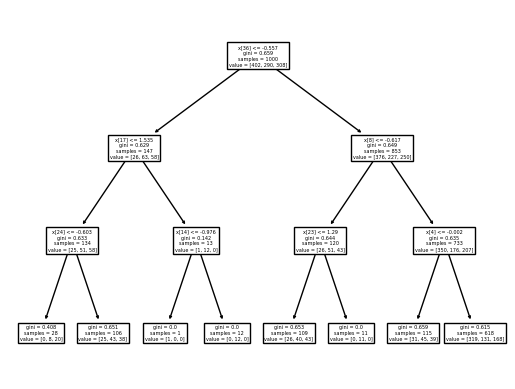

In [11]:
from sklearn import tree
X_subset, y_subset = X_train[:1000], y_train[:1000]
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_subset, y_subset)
tree.plot_tree(clf)
plt.savefig("images/tree.png")

In [31]:
forest = RandomForestClassifier(n_estimators=20, max_depth=5)
forest.fit(X_train, y_train)
preds = forest.predict(X_val)

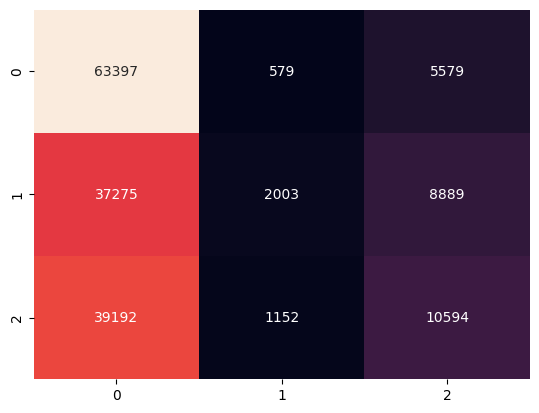

In [39]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, preds), annot=True, cbar=False, fmt=".0f")
plt.savefig("images/confusion_matrix.png")

In [33]:
from sklearn.model_selection import cross_val_score
cross_val_score(forest, X_train, y_train, cv=3)

array([0.45022679, 0.45036019, 0.45101588])

In [41]:
forest.score(X_val, y_val)

0.4505751215463062

# Réseaux de neurones

In [6]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(3, activation="softmax")
    ])
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [17]:
model = build_model()
num_epochs = 100
history = model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    batch_size=512,
    validation_split=0.2
)

Epoch 1/100
1055/1055 [==============================] - 6s 5ms/step - loss: 1.0455 - accuracy: 0.4479 - val_loss: 1.0343 - val_accuracy: 0.4565
Epoch 2/100
1055/1055 [==============================] - 6s 5ms/step - loss: 1.0252 - accuracy: 0.4686 - val_loss: 1.0239 - val_accuracy: 0.4684
Epoch 3/100
1055/1055 [==============================] - 6s 5ms/step - loss: 1.0156 - accuracy: 0.4793 - val_loss: 1.0166 - val_accuracy: 0.4722
Epoch 4/100
1055/1055 [==============================] - 6s 5ms/step - loss: 1.0079 - accuracy: 0.4862 - val_loss: 1.0164 - val_accuracy: 0.4736
Epoch 5/100
1055/1055 [==============================] - 6s 5ms/step - loss: 1.0027 - accuracy: 0.4922 - val_loss: 1.0122 - val_accuracy: 0.4769
Epoch 6/100
1055/1055 [==============================] - 5s 5ms/step - loss: 0.9981 - accuracy: 0.4967 - val_loss: 1.0127 - val_accuracy: 0.4766
Epoch 7/100
1055/1055 [==============================] - 6s 5ms/step - loss: 0.9929 - accuracy: 0.4988 - val_loss: 1.0078 - val_ac

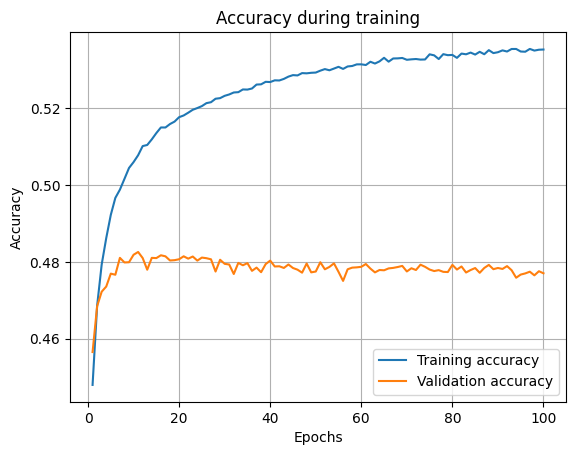

In [18]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, num_epochs + 1)
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.title("Accuracy during training")
plt.savefig("images/accuracy.png")

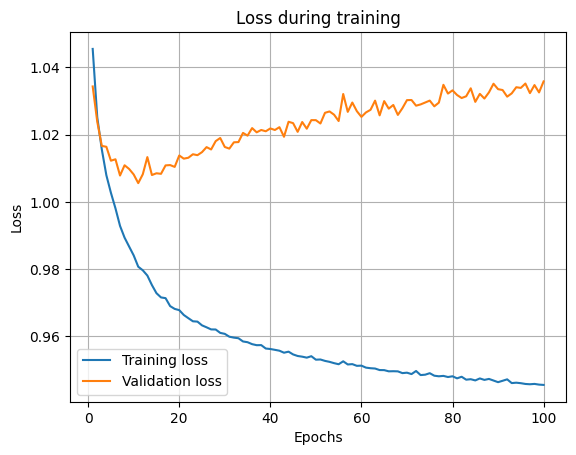

In [19]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, num_epochs + 1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.title("Loss during training")
plt.savefig("images/loss.png")

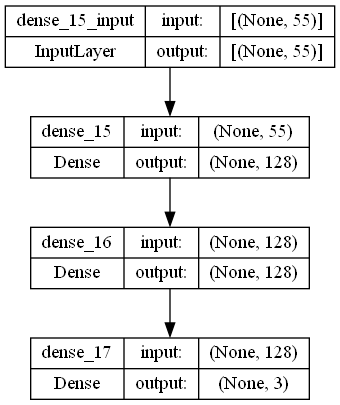

In [20]:
keras.utils.plot_model(model, to_file="images/model.png", show_shapes=True)

In [21]:
model.evaluate(X_val, y_val)

5271/5271 [==============================] - 13s 3ms/step - loss: 1.0386 - accuracy: 0.4757


[1.038583517074585, 0.4756788909435272]

In [22]:
model = build_model()

callbacks=[keras.callbacks.EarlyStopping(patience=5)]
history = model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    batch_size=512,
    callbacks=callbacks,
    validation_split=0.2
)

Epoch 1/100
1055/1055 [==============================] - 6s 5ms/step - loss: 1.0468 - accuracy: 0.4468 - val_loss: 1.0327 - val_accuracy: 0.4591
Epoch 2/100
1055/1055 [==============================] - 5s 5ms/step - loss: 1.0247 - accuracy: 0.4677 - val_loss: 1.0235 - val_accuracy: 0.4678
Epoch 3/100
1055/1055 [==============================] - 5s 5ms/step - loss: 1.0155 - accuracy: 0.4792 - val_loss: 1.0157 - val_accuracy: 0.4742
Epoch 4/100
1055/1055 [==============================] - 5s 5ms/step - loss: 1.0092 - accuracy: 0.4866 - val_loss: 1.0179 - val_accuracy: 0.4720
Epoch 5/100
1055/1055 [==============================] - 5s 5ms/step - loss: 1.0039 - accuracy: 0.4916 - val_loss: 1.0101 - val_accuracy: 0.4796
Epoch 6/100
1055/1055 [==============================] - 5s 5ms/step - loss: 0.9980 - accuracy: 0.4959 - val_loss: 1.0096 - val_accuracy: 0.4801
Epoch 7/100
1055/1055 [==============================] - 5s 5ms/step - loss: 0.9955 - accuracy: 0.4987 - val_loss: 1.0121 - val_ac

In [23]:
model.save("models/dense.keras")

In [24]:
model.evaluate(X_val, y_val)

5271/5271 [==============================] - 13s 3ms/step - loss: 1.0111 - accuracy: 0.4806


[1.011083722114563, 0.4806118905544281]

In [25]:
preds = model.predict(X_val)
preds

5271/5271 [==============================] - 7s 1ms/step


array([[0.36854255, 0.18381752, 0.4476399 ],
       [0.4948218 , 0.2973757 , 0.2078025 ],
       [0.81135523, 0.09682889, 0.09181587],
       ...,
       [0.3502026 , 0.554642  , 0.09515532],
       [0.35071447, 0.33489615, 0.31438938],
       [0.7571727 , 0.170967  , 0.07186031]], dtype=float32)

In [26]:
preds.argmax(axis=1)

array([2, 0, 0, ..., 1, 0, 0], dtype=int64)

In [34]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks=[keras.callbacks.TensorBoard(log_dir="logs/")]

history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=512,
    callbacks=callbacks,
    validation_split=0.2
)

Epoch 1/30
1055/1055 [==============================] - 6s 5ms/step - loss: 1.0443 - accuracy: 0.4458 - val_loss: 1.0262 - val_accuracy: 0.4590
Epoch 2/30
1055/1055 [==============================] - 5s 5ms/step - loss: 1.0206 - accuracy: 0.4649 - val_loss: 1.0124 - val_accuracy: 0.4708
Epoch 3/30
1055/1055 [==============================] - 6s 5ms/step - loss: 1.0039 - accuracy: 0.4803 - val_loss: 0.9985 - val_accuracy: 0.4834
Epoch 4/30
1055/1055 [==============================] - 6s 5ms/step - loss: 0.9926 - accuracy: 0.4903 - val_loss: 0.9945 - val_accuracy: 0.4853
Epoch 5/30
1055/1055 [==============================] - 6s 5ms/step - loss: 0.9839 - accuracy: 0.4962 - val_loss: 0.9926 - val_accuracy: 0.4860
Epoch 6/30
1055/1055 [==============================] - 5s 5ms/step - loss: 0.9775 - accuracy: 0.5023 - val_loss: 0.9913 - val_accuracy: 0.4870
Epoch 7/30
1055/1055 [==============================] - 5s 5ms/step - loss: 0.9708 - accuracy: 0.5063 - val_loss: 0.9923 - val_accuracy:

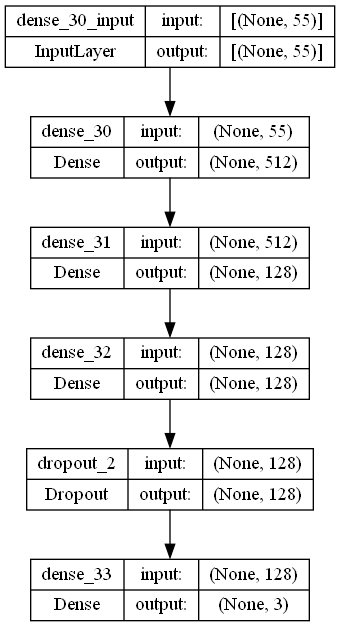

In [38]:
keras.utils.plot_model(model, to_file="images/dropout.png", show_shapes=True)

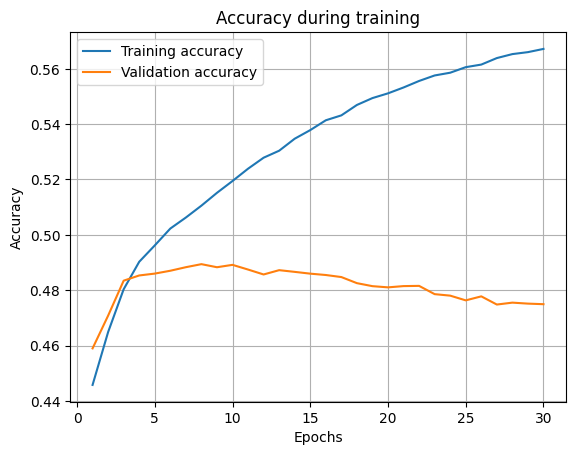

In [40]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, 30 + 1)
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.title("Accuracy during training")
plt.savefig("images/accuracy_dropout.png")

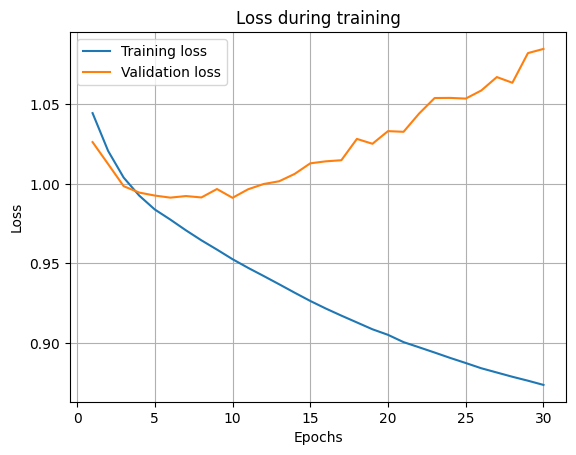

In [42]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, 30 + 1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.title("Loss during training")
plt.savefig("images/loss_dropout.png")

In [37]:
model.evaluate(X_val, y_val)

5271/5271 [==============================] - 15s 3ms/step - loss: 1.0903 - accuracy: 0.4748


[1.0902937650680542, 0.47478359937667847]

In [44]:
model = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.2
)

Epoch 1/100
1055/1055 [==============================] - 6s 5ms/step - loss: 1.0531 - accuracy: 0.4368 - val_loss: 1.0357 - val_accuracy: 0.4540
Epoch 2/100
1055/1055 [==============================] - 5s 5ms/step - loss: 1.0341 - accuracy: 0.4529 - val_loss: 1.0277 - val_accuracy: 0.4591
Epoch 3/100
1055/1055 [==============================] - 5s 4ms/step - loss: 1.0276 - accuracy: 0.4593 - val_loss: 1.0215 - val_accuracy: 0.4648
Epoch 4/100
1055/1055 [==============================] - 5s 4ms/step - loss: 1.0220 - accuracy: 0.4641 - val_loss: 1.0174 - val_accuracy: 0.4675
Epoch 5/100
1055/1055 [==============================] - 5s 5ms/step - loss: 1.0183 - accuracy: 0.4681 - val_loss: 1.0131 - val_accuracy: 0.4719
Epoch 6/100
1055/1055 [==============================] - 5s 4ms/step - loss: 1.0137 - accuracy: 0.4722 - val_loss: 1.0083 - val_accuracy: 0.4760
Epoch 7/100
1055/1055 [==============================] - 5s 4ms/step - loss: 1.0091 - accuracy: 0.4757 - val_loss: 1.0053 - val_ac

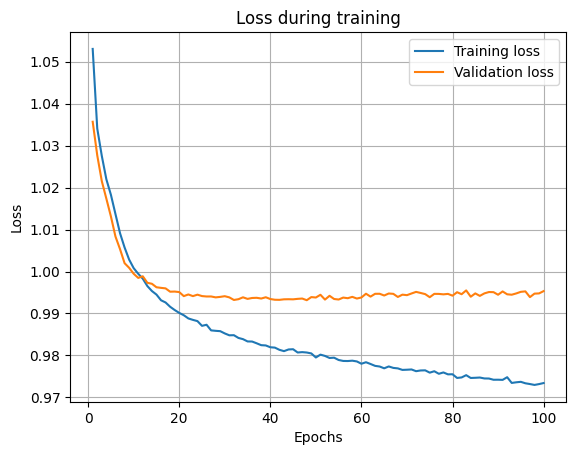

In [46]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, 100 + 1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.title("Loss during training")
plt.savefig("images/loss_dropout2.png")

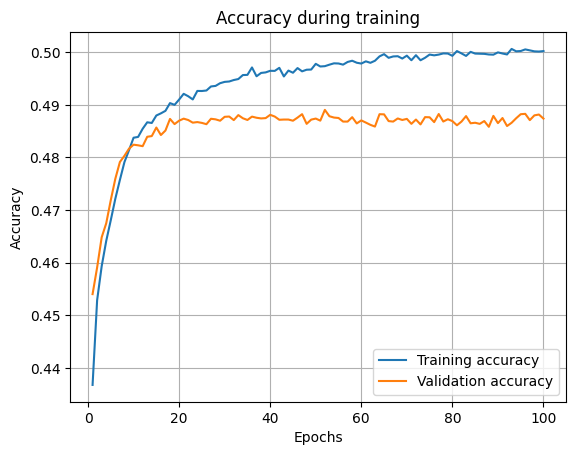

In [48]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, 100 + 1)
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.title("Accuracy during training")
plt.savefig("images/accuracy_dropout2.png")

# Gradient boosted trees

In [27]:
bst = XGBClassifier(
    n_estimators=10,
    max_depth=10,
    learning_rate=1,
    objective="multi:softmax",
    num_class=3
)

bst.fit(X_train, y_train);

In [28]:
bst.score(X_train, y_train)

0.6114247768065587

In [29]:
bst.score(X_val, y_val)

0.5251215463061781

In [30]:
preds = bst.predict(X_val)
preds[:10]

array([1, 0, 0, 2, 1, 0, 0, 2, 0, 0])